<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/V3_COMPAS_Clustering_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

# LOAD (META) DATA

In [58]:
data_shaper = pd.read_csv('/content/Compas_error_shap.csv')
#data_shaperr.head()
#data_shaperr.info()
#data_shaper.iloc[3]

In [59]:
#Master Dataset
META_COL = ['clusters', 'new_clusters']
META_COL_VIZ = ['Error_Type']

ERROR_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
BASIC_COL = ['age', 'decile_score', 'priors_count']
DUMMY_COL = ['sex_Female', 'sex_Male','race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
                      'race_Native American', 'race_Other']

ERROR_COL_scaled = ['errors_scaled', 'TP_scaled', 'TN_scaled', 'FN_scaled', 'FP_scaled']
BASIC_COL_scaled = ['age_scaled', 'decile_score_scaled', 'priors_count_scaled']
DUMMY_COL_scaled = ['sex_Female_scaled', 'sex_Male_scaled', 'race_Native American_scaled','race_Other_scaled',
                'race_African-American_scaled', 'race_Asian_scaled', 'race_Caucasian_scaled', 'race_Hispanic_scaled']

#SHAP is created on BASIC_COL_scaled and DUMMY_COL_scaled
SHAP_BASIC = ['Shap_age', 'Shap_decile_score', 'Shap_priors_count']
SHAP_DUMMY = ['Shap_sex_Female', 'Shap_sex_Male','Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
                         'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other']

SHAP_BASIC_scaled = ['Shap_age_scaled', 'Shap_decile_score_scaled', 'Shap_priors_count_scaled']
SHAP_DUMMY_scaled = ['Shap_sex_Female_scaled', 'Shap_sex_Male_scaled','Shap_race_African-American_scaled',
                     'Shap_race_Asian_scaled', 'Shap_race_Caucasian_scaled','Shap_race_Hispanic_scaled',
                     'Shap_race_Native American_scaled', 'Shap_race_Other_scaled']

# DATA PREP UTILS

In [60]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def drop_zero_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def drop_zero_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

TPFN_all = drop_zero_TP_FN(data_shaper)
TNFP_all = drop_zero_TN_FP(data_shaper)


In [61]:
#convert Error_Type to numeric labels
#TPFN_all['Error_Type'] = TPFN_all['Error_Type'].map({'FN': 0, 'FP': 1, 'TP': 2, 'TN': 3})
#TNFP_all['Error_Type'] = TNFP_all['Error_Type'].map({'FN': 0, 'FP': 1, 'TP': 2, 'TN': 3})

In [62]:
#drop Na's
TPFN_all = TPFN_all.dropna()
TNFP_all = TNFP_all.dropna()

In [63]:
#create scaled and unscaled versions of TPFN - TNFP
TPFN_scaled = TPFN_all.drop(BASIC_COL + DUMMY_COL + ERROR_COL + SHAP_BASIC + SHAP_DUMMY, axis=1)
TPFN_unscaled = TPFN_all.drop(BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, axis=1)
TNFP_scaled = TNFP_all.drop(BASIC_COL + DUMMY_COL + ERROR_COL + SHAP_BASIC + SHAP_DUMMY, axis=1)
TNFP_unscaled = TNFP_all.drop(BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, axis=1)

TPFN_scaled.iloc[3]
#TNFP_unscaled.iloc[3]

age_scaled                          -0.237043
decile_score_scaled                  1.572172
priors_count_scaled                  0.927366
sex_Female_scaled                   -0.489624
sex_Male_scaled                      0.489624
race_African-American_scaled        -1.024986
race_Asian_scaled                    -0.06675
race_Caucasian_scaled                1.392728
race_Hispanic_scaled                -0.311212
race_Native American_scaled         -0.050014
race_Other_scaled                   -0.234822
Error_Type                                 TP
Shap_age_scaled                      0.023265
Shap_decile_score_scaled             0.078974
Shap_priors_count_scaled            -0.234463
Shap_sex_Female_scaled               0.568482
Shap_sex_Male_scaled                 0.492711
Shap_race_African-American_scaled    1.873989
Shap_race_Asian_scaled               0.048762
Shap_race_Caucasian_scaled           0.857553
Shap_race_Hispanic_scaled            7.964147
Shap_race_Native American_scaled  

In [64]:
def initialize_dataset(data, meta_col=True, with_error_col =True, with_classes=True):
    """
    Prepare the dataset by scaling the features and adding new columns for clusters = 0 and new_clusters = -1 which is required for HBAC.

    PARAM:
    - data: input dataset.
    - meta_col (bool): If True, keeps META_COL in the final dataset
    - with_error_col (bool): If True, includes ERROR_COL in the features to scale
    - with_classes (bool): If True, retains class columns from META_COL in the new dataset

    Returns:
    - pd.DataFrame: dataset with scaled features and cluster columns.
    """

    # 1. Make deep copy of the dataset
    new_data = data.copy(deep=True)

    # 2. Ignore META_COL and META_COL_viz for scaling and add them back in step 4
    if meta_col:
      columns_to_drop = META_COL + META_COL_VIZ
      columns_to_drop = [col for col in columns_to_drop if col in new_data.columns]
      new_data = new_data.drop(columns=columns_to_drop, errors='ignore')

    # 3. Scale features
    features_to_scale = new_data.columns.tolist()
    if not with_error_col:
        features_to_scale = [col for col in features_to_scale if col not in ERROR_COL + ERROR_COL_scaled]

    scaler = StandardScaler()
    new_data[features_to_scale] = scaler.fit_transform(new_data[features_to_scale])

    # 5. Add back META_COL_VIZ and META_COL_VIZ if required
    if meta_col:
        for col in META_COL:
            if col in data.columns:
                new_data[col] = data[col]
    for col in META_COL_VIZ:
        if col in data.columns:
            new_data[col] = data[col]

    # Initialize clusters and new_clusters columns
    new_data['clusters'] = 0
    new_data['new_clusters'] = -1

    return new_data

In [65]:
# Example usage
#TPFN_init = initialize_dataset(TPFN_unscaled, meta_col=True, with_error_col=True, with_classes=True)
#TNFP_init = initialize_dataset(TNFP_unscaled, meta_col=True, with_error_col=True, with_classes=True)
TPFN_init = initialize_dataset(TPFN_scaled, meta_col=True, with_error_col=True, with_classes=True) # Check (it will give the same dataset)
TNFP_init = initialize_dataset(TNFP_scaled, meta_col=True, with_error_col=True, with_classes=True)
#TPFN_init.iloc[3]
TNFP_init.iloc[3]
#TNFP_init2.iloc[3]


age_scaled                          -0.480655
decile_score_scaled                 -0.240149
priors_count_scaled                  0.168178
sex_Female_scaled                    -0.52862
sex_Male_scaled                       0.52862
race_African-American_scaled        -0.895162
race_Asian_scaled                    -0.07169
race_Caucasian_scaled               -0.792353
race_Hispanic_scaled                 3.100388
race_Native American_scaled         -0.054133
race_Other_scaled                    -0.26841
Shap_age_scaled                     -1.239822
Shap_decile_score_scaled            -1.460343
Shap_priors_count_scaled            -1.022759
Shap_sex_Female_scaled               0.247435
Shap_sex_Male_scaled                 0.283493
Shap_race_African-American_scaled   -0.174953
Shap_race_Asian_scaled               0.010215
Shap_race_Caucasian_scaled          -0.439667
Shap_race_Hispanic_scaled            0.123179
Shap_race_Native American_scaled     0.041392
Shap_race_Other_scaled            

In [66]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

# UTILS for BIAS in ERROR DIFFERENCE

In [67]:
#Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error() from V1
def get_error_rate(data, column = 'errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty cluster')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

'''Calculate BIAS in terms of Error Difference
bias_type can be 'negative', 'positive' or 'absolute'
baseline can be 'all' which is the overall error rate, or 'other' or 'best' '''

def get_error_diff(data, cluster_id, cluster_col, bias_type = 'negative', baseline= 'all'):
  cluster_x= data.loc[data[cluster_col] == cluster_id]
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]

  if len(cluster_x) == 0:
    print ('calculating error difference on an empty cluster')
    return

  if baseline == 'all':
    error_diff = get_error_rate(cluster_x) - get_error_rate(data)

  elif baseline == 'other':
    if len(remaining_clusters) == 0:
      print ("This cluster is the entire dataset. Cluster:", cluster_id)
      return
    error_diff = get_error_rate(cluster_x) - get_error_rate(remaining_clusters)

  elif baseline == 'best':
    best_cluster = get_min_bias_cluster(data, cluster_col, bias_type, baseline)
    error_diff = get_error_rate(cluster_x) - best_cluster[1]

  else:
    print ('unknown baseline')
    return

  #if full_info:
    #return [error_diff, function(cluster_x), function(remaining_clusters)]

  if bias_type == 'negative':
    pass #no change needed
  elif bias_type == 'positive':
    error_diff = -error_diff
  elif bias_type == 'absolute':
    error_diff = np.absolute(error_diff)
  else:
    print("unknown bias type")
    return

  return error_diff

# UTILS for VISUALS

PCA

In [106]:
def pca_plot(data, title, alpha, pca_columns, other_columns, error):

  if title is None:
        title = f'K-means for {error}\n'

  if not isinstance(pca_columns, list):
      raise ValueError ("pca columns should be a list of column names")

  # Check if the selected columns are in the dataframe
  for col in pca_columns:
    if col not in data.columns:
      raise ValueError(f"{col} not in dataframe")

  # Initialize other_columns to empty list if not provided
  if other_columns is None:
        other_columns = []

    # Ensure other_columns is a list and contains valid columns
  if not isinstance(other_columns, list):
      raise ValueError("other_columns should be a list of column names.")

    # Exclude pca_columns from other_columns
  exclude_columns = pca_columns
  other_columns = [col for col in data.columns if col not in exclude_columns]

    # Extract features for PCA and drop Meta_colums
  pca_features = data[pca_columns]
  other_features = data[pca_columns]

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
  pca = PCA(n_components=2)
  pca_result = pca.fit_transform(pca_features)
  pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['PC1', 'PC2'])

    # Ensure Error_Type is in the other_features
  if 'Error_Type' in data.columns:
        pca_df['Error_Type'] = data['Error_Type']

    # Create temporary dataset that contains both principal components and other features
  temp_dataset = pca_df.join(other_features, how='left')

  if 'Error_Type' not in temp_dataset.columns:
        raise ValueError("Column 'Error_Type' not found in the DataFrame. Ensure it is present for hue mapping.")

  scatterplot = sns.scatterplot(data=temp_dataset, x='PC1', y='PC2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
  scatterplot.set_title(title)
  scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

  explained_variance_ratio = pca.explained_variance_ratio_
  print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

  plt.show()

TSNE

In [96]:
'''PARAMS:
    - alpha: float, transparency level for plot points
    - tsne_columns: list of str, columns used for t-SNE
    - error: str type for title
    - perplexity: float, perplexity parameter for t-SNE
    - learning_rate: float,learning rate parameter for t-SNE
    - other_columns: list of str, other columns to include in the plot

'''
def tsne_plot(data, title, perplexity, learning_rate, n_iter, alpha, tsne_columns, other_columns = None, error= 'FN'):

    if title is None:
        title = f'K-means for {error}\n'

    # Ensure tsne_columns is a list and contains valid columns
    if not isinstance(tsne_columns, list):
        raise ValueError("tsne_columns should be a list of column names.")

    # Check if the selected columns are in the dataframe
    for col in tsne_columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' is not in the dataframe.")

    # Initialize other_columns to empty list if not provided
    if other_columns is None:
        other_columns = []

    # Ensure other_columns is a list and contains valid columns
    if not isinstance(other_columns, list):
        raise ValueError("other_columns should be a list of column names.")

    # Exclude tsne_columns from other_columns
    exclude_columns = tsne_columns
    other_columns = [col for col in data.columns if col not in exclude_columns]

    # Extract features for t-SNE
    tsne_features = data[tsne_columns]
    other_features = data[other_columns]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()

In [70]:
#TPFN_init.info()

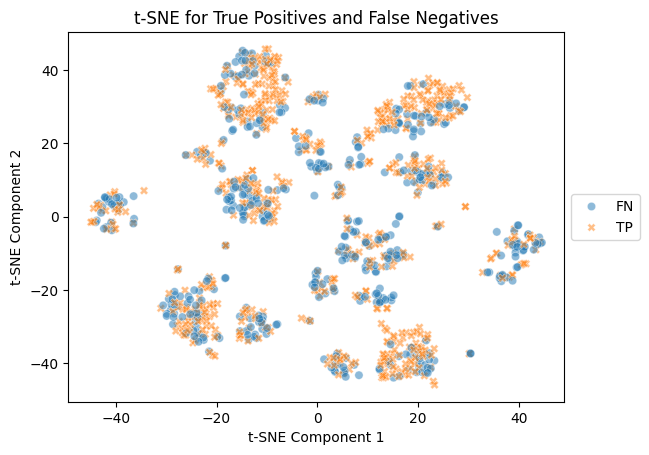

In [108]:
#pca_plot(TPFN_init, title=None, alpha = 0.5, pca_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, error='FN')

tsne_plot(TPFN_init, title='t-SNE for True Positives and False Negatives', alpha = 0.5, tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, error='FN', perplexity=30, learning_rate =200, n_iter= 1000)

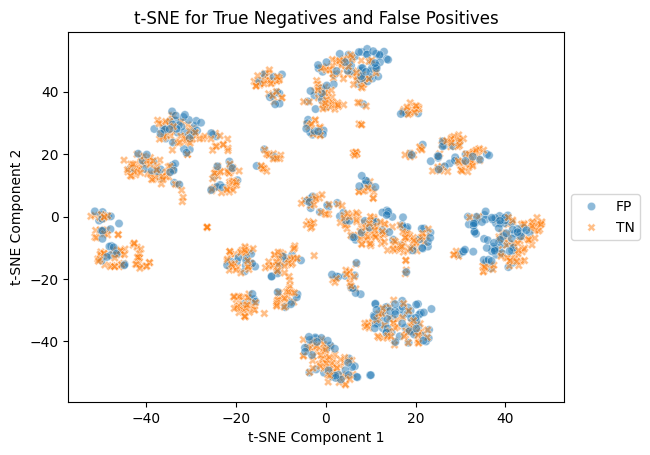

In [109]:
#pca_plot(TNFP_init, error = 'FP', title=None, alpha = 0.5, pca_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None)
tsne_plot(TNFP_init, error= 'FP', title='t-SNE for True Negatives and False Positives', alpha=0.5, tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, perplexity=30, learning_rate =200, n_iter= 1000)

# UTILS FOR CLUSTERING

In [ ]:
#get cluster with max error difference
def get_max_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  max_bias = 0 #min possible bias
  max_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue

    current_bias = function(data, cluster_id, cluster_col, bias_type, baseline) #pos function to find highest bias

    if current_bias > max_bias:
      max_bias = current_bias
      max_bias_cluster = cluster_id

    return(max_bias_cluster, max_bias)

#get cluster with min error difference
def get_min_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  min_bias = 1 #max possible bias and look for smt smaller
  min_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue
    current_bias = function(data, cluster_id, cluster_col, bias_type, baseline)
    if current_bias < min_bias:
      min_bias = current_bias
      min_bias_cluster = cluster_id
  return(min_bias_cluster, min_bias)

#get size of the smallest cluster
def get_min_cluster_size(data, cluster_col = 'new_clusters'):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1: #exclude the -1 clusters as they may present outliers (in dbscan?)
      continue
      size = len(data.loc[data['new_clusters'] == i])
      if size < min_cluster_size: #update if new cluster size is smaller
        min_cluster_size = size
  return(min_cluster_size)

def get_random_cluster(data, cluster_col, min_splittable_cluster_size, previous_cluster, all_cluster_ids):
  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1 or candidate_cluster_id == previous_cluster:
      continue
      print ('This is the random cluster we picked:', candidate_cluster_id)

      candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]
      if len(candidate_cluster) >= min_splittable_cluster_size:
        print('it is too small:', len(candidate_cluster))
        continue
      else:
        return candidate_cluster_id

def select_new_cluster(data, cluster_col='clusters', error_column='errors', overall_error_rate=0.5, bias_type='negative', baseline='all'):
    smallest_diff = float('inf')
    selected_cluster = None

    for cluster_id in data[cluster_col].unique():
        if cluster_id == -1: #skip outlier
            continue

        error_diff = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline) #calculate the error_diff for each cluster

        if error_diff is None:
            continue

        abs_diff = abs(overall_error_rate - (get_error_rate(data[data[cluster_col] == cluster_id]))) #get cluster with the smallest absolute difference with the overall error rate (0.5)

        if abs_diff < smallest_diff:
            smallest_diff = abs_diff
            selected_cluster = cluster_id
    return selected_cluster

def exit_clustering(data, msg='', bias_type='', iter=''):
  print('Iteration ', iter, ': ', msg)
  print('Overall error rate: ', get_error_rate(data))
  for c in np.sort(data['clusters'].unique()):
    print('Cluster: ', c, '\tSize: ', len(data.loc[data['clusters'] == c]), '\tError rate: ', get_error_rate(data.loc[data['clusters'] == c]))
  pca_plot(data,'HBAC-DBSCAN on COMPAS - ' + bias_type + ' bias', hue='clusters', s=15, alpha=0.8)
  return data


# K-MEANS CLUSTERING

In [ ]:
def hbac_kmeans(data, columns_to_drop = [], error='FN', max_iter=300, show_plot=True):
    clus_model_kwargs = {
        "n_clusters": 2,  # Nr of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    if not isinstance(data, pd.DataFrame):
        raise TypeError(f"Expected data to be a DataFrame, but got {type(data)} instead.")

    x = 0  # Initial cluster nr & bias value
    initial_bias = 0

    error_list = []
    error_rate = get_error_rate(data, column=error)  # Calculating mean error rate on the specified error column

    min_splittable_cluster_size = round(0.05 * len(data))  # Min size of cluster to be split
    min_acceptable_cluster_size = round(0.03 * len(data))  # Min acceptable size of cluster after split
    print("error rate:", error_rate)

    # Iterative clustering loop
    for i in range(1, max_iter):
        if len(data['clusters'].unique()) != 1:  # Check for multiple clusters
            error_list.append(get_error_rate(data, column=error))  # Calculate and store error rate
            data['new_clusters'] = -1  # Reset new clusters

        candidate_cluster = data.loc[data['clusters'] == x]  # Select subset data for the current cluster

        if len(candidate_cluster) < min_splittable_cluster_size:  # Check for size
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())
            continue

        # Select only numeric columns for K-means
        numeric_columns = candidate_cluster.select_dtypes(include=[np.number]).columns

        # Ensure only existing columns are being dropped
        columns_to_drop_valid = [col for col in columns_to_drop if col in numeric_columns]

        if not isinstance(candidate_cluster, pd.DataFrame):
          raise TypeError(f"Expected candidate_cluster to be a DataFrame, but got {type(candidate_cluster)} instead.")

        kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[numeric_columns].drop(columns=columns_to_drop, errors='ignore'))

        candidate_cluster['new_clusters'] = pd.DataFrame(kmeans.predict(candidate_cluster[numeric_columns].drop(columns=columns_to_drop, errors='ignore')), index=candidate_cluster.index)

        print(f"Type of data before combining: {type(data)}")
        print(f"Type of candidate_cluster['new_clusters']: {type(candidate_cluster['new_clusters'])}")

        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters']) # Combine new clusters with existing ones

        print(f"Type of data after combining: {type(data)}")

        discr_bias = get_error_diff(data, x, 'clusters', bias_type='negative', baseline='all')  # Determine discriminative bias
        print('discriminative bias:', discr_bias)

        min_cluster_size = get_min_cluster_size(data)
        print('Smallest cluster size:', min_cluster_size)

        if (discr_bias >= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
            print("adding a new cluster")

            if not isinstance(data, pd.DataFrame):
              raise TypeError(f"Expected data to be a DataFrame, but got {type(data)} instead.")

            n_cluster = max(data['clusters'])
            data.loc[data['new_clusters'] == 1, 'clusters'] = n_cluster + 1


            if show_plot:
                tsne_plot(data, columns_to_drop, error, perplexity=30, learning_rate=200, n_iter=1000, alpha=0.5)
                plt.show()

            x = select_new_cluster(data, error_column=error) #if error_rate is not None else None)
            initial_bias = discr_bias

        else:
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())

    print('max_iter')
    print(error_list)
    return data

'''

# OLD VERSION
def hbac_kmeans(data, columns_to_drop = [], error='FN', max_iter=300, show_plot=True):
    clus_model_kwargs = {
        "n_clusters": 2,  # Nr of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Nr of times k-means is run with different centroid seeds
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    x = 0  # Initial cluster number
    initial_bias = 0  # Initial bias value

    error_list = []

    if error in data.columns:
        error_rate = get_error_rate(data, column=error)  # Calculating mean error rate on the specified error column
        print("error rate:", error_rate)
    else:
        print(f"Error column '{error}' not found in the dataset. Skipping error-based calculations.")
        error_rate = None

    min_splittable_cluster_size = round(0.05 * len(data))  # Min size of cluster to be split
    min_acceptable_cluster_size = round(0.03 * len(data))  # Min acceptable size of cluster after split

    # Iterative clustering loop
    for i in range(1, max_iter):
        if len(data['clusters'].unique()) != 1:  # Check if there are multiple clusters
            if error_rate is not None: #check if there is an error column
                error_list.append(get_error_rate(data, column=error))  # Calculate and store error rate in error_list
            data['new_clusters'] = -1  # update or resets a new column in new clusters with -1

        candidate_cluster = data.loc[data['clusters'] == x]  # Select subset data for the current cluster

        if len(candidate_cluster) < min_splittable_cluster_size:  # Check for size
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())
            continue

        # Select only numeric columns for K-means
        numeric_columns = candidate_cluster.select_dtypes(include=[np.number]).columns

        # Drop META_COL and optionally ERROR_COL based on the provided dataset
        columns_to_drop = META_COL
        if any(col in data.columns for col in ERROR_COL):  # Check if any of the ERROR_COL are present in the dataset
            columns_to_drop += ERROR_COL

        # Ensure that only existing columns are being dropped
        columns_to_drop = [col for col in columns_to_drop if col in numeric_columns]

        kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[numeric_columns].drop(columns=columns_to_drop, errors='ignore'))

        candidate_cluster['new_clusters'] = pd.DataFrame(
            kmeans.predict(candidate_cluster[numeric_columns].drop(columns=columns_to_drop, errors='ignore')),
            index=candidate_cluster.index)
        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])  # Combine new clusters with existing ones

        if error_rate is not None:
            discr_bias = get_error_diff(data, x, 'clusters', bias_type='negative', baseline='all')  # Determine discriminative bias
            print('discriminative bias:', discr_bias)
        else:
            discr_bias = 0

        min_cluster_size = get_min_cluster_size(data)
        print('Smallest cluster size:', min_cluster_size)

        if (discr_bias >= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
            print("adding a new cluster")
            n_cluster = max(data['clusters'])
            data['clusters'][data['new_clusters'] == 1] = n_cluster + 1

            if show_plot:
                plot_title = f'K-means for {error} Errors' if error_rate is not None else 'K-means Clustering'
                tsne_plot(data, plot_title, perplexity=30, learning_rate=200, n_iter=1000, alpha=0.5)
                plt.show()

            x = select_new_cluster(data, error_column=error if error_rate is not None else None)
            initial_bias = discr_bias

        else:
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())

    print('MAX_ITER')
    if error_rate is not None:
        print(error_list)
    return data
'''

'\n\n# OLD VERSION\ndef hbac_kmeans(data, columns_to_drop = [], error=\'FN\', max_iter=300, show_plot=True):\n    clus_model_kwargs = {\n        "n_clusters": 2,  # Nr of clusters to form\n        "init": "k-means++",  # Centroids initialization method\n        "n_init": 10,  # Nr of times k-means is run with different centroid seeds\n        "max_iter": max_iter,  # Maximum iterations for a single run\n    }\n\n    x = 0  # Initial cluster number\n    initial_bias = 0  # Initial bias value\n\n    error_list = []\n\n    if error in data.columns:\n        error_rate = get_error_rate(data, column=error)  # Calculating mean error rate on the specified error column\n        print("error rate:", error_rate)\n    else:\n        print(f"Error column \'{error}\' not found in the dataset. Skipping error-based calculations.")\n        error_rate = None\n\n    min_splittable_cluster_size = round(0.05 * len(data))  # Min size of cluster to be split\n    min_acceptable_cluster_size = round(0.03 * l

In [ ]:
print(type(TNFP_init['clusters']))

<class 'pandas.core.series.Series'>


# RQ'S


**RQ1: is there a relationshop between shap & risk of error?**

TPFN_init & TNFP_init = *all columns*

SE = shap and error columns

FE = all columns except shap (selma)


--------------------------------------------------
**RQ2: does shap help in finding disc clusters?**

FS = all columns except error

S = only SHAP_COL

F = only BASIC_COL


# SHAP & ERROR & BASIC COL

***Clustering all columns TP FN DATA***

In [ ]:
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TPFN_init, columns_to_drop = [], error= 'FN', max_iter = 300, show_plot= True)
plt.show()

error rate: 0.42290748898678415
Type of data before combining: <class 'pandas.core.frame.DataFrame'>
Type of candidate_cluster['new_clusters']: <class 'pandas.core.series.Series'>
Type of data after combining: <class 'pandas.core.frame.DataFrame'>
discriminative bias: 0.0
Smallest cluster size: 1589
adding a new cluster


TypeError: 'tuple' object is not callable

In [ ]:
c= get_max_bias_cluster(TPFN_init)

Mean_error_rate_TPFN = get_error_rate(TPFN_init)

print ('Mean error rate of full TPFN data set:', Mean_error_rate_TPFN)

print (f" cluster {c} has the highest discrimination bias for TPFN data")


***TPFN ALL COLUMNS ANOVA***

In [ ]:
'''SHAP, ERROR & BASIC COLUMNS FOR TPFN ANOVA'''
groupstpfn = TPFN_init.groupby('clusters')['FN'].apply(list)
anovatpfn = [np.array(groupstpfn) for groupstpfn in groupstpfn]

f_stat, p_val = f_oneway(*anovatpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

***Clustering all columns TN FP DATA***

In [ ]:
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data =TNFP_init, columns_to_drop = [], error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(TNFP_init)

Mean_error_rate_TNFP = get_error_rate(TNFP_init)

print ('Mean error rate of full TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for TNFP data")


***TNFP ALL COLUMNS ANOVA***

In [ ]:
'''SHAP, ERROR & BASIC COLUMNS FOR TNFP ANOVA'''
groupstnfp = TNFP_init.groupby('clusters')['FP'].apply(list)
anovatnfp = [np.array(groupstnfp) for groupstnfp in groupstnfp]

f_stat, p_val = f_oneway(*anovatnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# SHAP & ERROR COLUMNS NO BASIC FEATURES

In [ ]:
'''SE: SHAP_COL and ERROR_COL no BASIC_COL '''
columns_to_drop = BASIC_COL_unscaled + DUMMY_unscaled
SE_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
SE_TNFP = TNFP_init.drop(columns_to_drop, axis=1) #scaled

#SE_TPFN.iloc[3]
SE_TNFP.iloc[3]

***SHAP AND ERROR KMEANS ON TPFN***

In [ ]:
'''KMEANS SHAP & ERROR COLUMNS FOR TPFN'''
TPFN_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TPFN_init, columns_to_drop = ['BASIC_COL_unscaled' , 'DUMMY_unscaled'], error= 'FN', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(SE_TPFN)

Mean_error_rate_SE_TPFN = get_error_rate(SE_TPFN)

print ('Mean error rate of SE_TPFN data set:', Mean_error_rate_SE_TPFN)

print (f" cluster {c} has the highest discrimination bias for TPFN data")

***SHAP AND ERROR ANOVA ON TPFN***

In [ ]:
'''SHAP & ERROR COLUMNS FOR TPFN ANOVA'''
groupsSE_tpfn = SE_TPFN.groupby('clusters')['FN'].apply(list)
anovaSE_tpfn = [np.array(groupsSE_tpfn) for groupsSE_tpfn in groupsSE_tpfn]

f_stat, p_val = f_oneway(*anovaSE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

***SHAP AND ERROR KMEANS ON TNFP***

In [ ]:
'''KMEANS SHAP & ERROR COLUMNS FOR TNFP'''
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TNFP_init, columns_to_drop = ['BASIC_COL_unscaled', 'DUMMY_unscaled'], error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(SE_TNFP)

Mean_error_rate_SE_TNFP = get_error_rate(SE_TNFP)

print ('Mean error rate of TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for TPFN data")

***SHAP AND ERROR ANOVA ON TNFP***

In [ ]:
'''SHAP & ERROR COLUMNS FOR TNFP ANOVA'''
groupsSE_tnfp = SE_TNFP.groupby('clusters')['FP'].apply(list)
anovaSE_tnfp = [np.array(groupsSE_tpfn) for groupsSE_tnfp in groupsSE_tnfp]

f_stat, p_val = f_oneway(*anovaSE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

In [ ]:
SE_TNFP.iloc[3]

# ERROR AND BASIC COLUMNS NO SHAP (SELMA)

In [ ]:
TPFN_init.iloc[3]

In [ ]:
'''FE: FEATURES AND ERROR NO SHAP (Selma) '''
columns_to_drop = SHAP_COL_Basic_scaled + SHAP_COL_Dummy_scaled

FE_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
FE_TNFP = TNFP_init.drop(columns_to_drop, axis=1) #scaled

FE_TPFN.iloc[3]
#FE_TNFP.iloc[3]

***BASIC & ERROR K-MEANS ON TPFN***

In [ ]:
'''BASIC & ERROR K-MEANS ON TPFN'''
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TPFN_init, columns_to_drop = ['SHAP_COL_Basic_scaled', 'SHAP_COL_Dummy_scaled'], error= 'FN', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(FE_TPFN)

Mean_error_rate_FE_TPFN = get_error_rate(FE_TPFN)

print ('Mean error rate of FE_TPFN data set:', Mean_error_rate_TPFN)

print (f" cluster {c} has the highest discrimination bias for FE_TPFN data")

In [ ]:
FE_TPFN.iloc[3]

***BASIC & ERROR ANOVA ON TPFN***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TPFN ANOVA'''
groupsFE_tpfn = FE_TPFN.groupby('clusters')['FN'].apply(list)
anovaFE_tpfn = [np.array(groupsFE_tpfn) for groupsFE_tpfn in groupsFE_tpfn]

f_stat, p_val = f_oneway(*anovaFE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

***BASIC & ERROR K-MEANS ON TNFP***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TNFP'''
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TNFP_init, columns_to_drop= ['SHAP_COL_Basic_scaled', 'SHAP_COL_Dummy_scaled'], error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(FE_TNFP)

Mean_error_rate_FE_TNFP = get_error_rate(FE_TNFP)

print ('Mean error rate of FE_TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for FE_TNFP data")

***BASIC & ERROR ANOVA ON TNFP***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TNFP ANOVA'''
groupsFE_tnfp = FE_TNFP.groupby('clusters')['FP'].apply(list)
anovaFE_tnfp = [np.array(groupsFE_tnfp) for groupsFE_tnfp in groupsFE_tnfp]

f_stat, p_val = f_oneway(*anovaFE_tnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# SHAP & BASIC COLUMNS NO ERROR

In [ ]:
#TPFN_init.iloc[3]

In [ ]:
'''FS: FEATURES AND SHAP NO ERROR '''
columns_to_drop = ERROR_COL

FS_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
FS_TNFP = TNFP_init.drop(columns_to_drop, axis=1) #scaled

FS_TPFN = initialize_dataset(FS_TPFN, unscaled=True, meta_col=True, with_error_col= False, with_classes=True)
FS_TNFP = initialize_dataset(FS_TNFP, unscaled=True, meta_col=True, with_error_col= False, with_classes=True)

FS_TPFN.iloc[3]
#FE_TNFP.iloc[3]

***BASIC & SHAP KMEANS ON TPFN***

In [ ]:
#Run it on TPFN_init and drop columns ERROR as you go through loop in clustering otherwise it doesn't work
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data=TPFN_init, columns_to_drop= ['ERROR_COL'], error='FN', max_iter=300, show_plot=True)

***BASIC & SHAP ANOVA ON TPFN***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsFS_tpfn = FS_TPFN.groupby('clusters')['Error_Type'].apply(list)
anovaFS_tpfn = [np.array(groupsFS_tpfn) for groupsFS_tpfn in groupsSE_tpfn]

f_stat, p_val = f_oneway(*anovaFS_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

***BASIC & SHAP KMEANS ON TNFP***

In [ ]:
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data=TNFP_init, columns_to_drop=['ERROR_COL', 'META_COL'], error='FP', max_iter=300, show_plot=True)

***BASIC & SHAP ANOVA ON TNFP***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsFS_tnfp = FS_TNFP.groupby('clusters')['FP'].apply(list)
anovaFS_tnfp = [np.array(groupsFS_tnfp) for groupsFS_tnfp in groupsSE_tnfp]

f_stat, p_val = f_oneway(*anovaFS_tnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# ONLY SHAP COL

In [ ]:
columns_to_drop = BASIC_COL_unscaled + DUMMY_unscaled + ERROR_COL
S_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
S_TNFP = TNFP_init.drop(columns_to_drop, axis=1)

S_TPFN.iloc[23]

***SHAP KMEANS ON TPFN***

In [ ]:
TPFN_init_S = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
#pass original dataset and not SE_TPFN otherwise the clustering doesn't work
hbac_kmeans(data = TPFN_init_S, columns_to_drop = ['BASIC_COL_unscaled', 'DUMMY_unscaled', 'ERROR_COL'], error= 'FN', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
MAXnegbias = get_max_bias_cluster(TPFN_init_S, bias_type='negative', baseline='all')
#highest_biased_cluster = TPFN_init_S[TPFN_init_S['clusters'] == c]

print ('cluster ID with the max negative bias is (1st score) against a minimum possible bias of (2nd score)', (max_neg_bias))

MINnegbias = get_min_bias_cluster(TPFN_init_S, bias_type = 'negative', baseline = 'all')
print ('cluster ID with the min negative bias is (1st score) against a maximum possible  ', (min_neg_bias))

MAXposbias = get_max_bias_cluster(TPFN_init_S, bias_type='positive', baseline='all')
print ('cluster ID with the max positive bias is (1st score) against a minimum possible bias of (2nd score)', (max_pos_bias))

MINposbias = get_min_bias_cluster(TPFN_init_S, bias_type = 'positive', baseline = 'all')
print ('cluster ID with the min positive bias is (1st score) against a maximum possible  ', (min_pos_bias))



***SHAP ANOVA ON TPFN***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsS_tpfn = TPFN_init_S.groupby('clusters')['FN'].apply(list)

# Check the number of groups
print("Number of groups:", len(groupsS_tpfn))

anovaS_tpfn = [np.array(groupsS_tpfn) for groupsS_tpfn in groupsS_tpfn]

# Proceed with ANOVA only if there are at least two groups
if len(anovaS_tpfn) >= 2:
    f_stat, p_val = f_oneway(*anovaS_tpfn)

    print('F-statistic:', f_stat)
    print('p-value:', p_val)

    alpha = 0.05
    if p_val < alpha:
        print("there are statistically significant differences between the clusters.")
    else:
        print("there are no statistically significant differences between the clusters")
else:
    print("ANOVA cannot be performed with less than two groups.")

***SHAP KMEANS ON TNFP***

In [ ]:
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data = TNFP_init, columns_to_drop = ['BASIC_COL_unscaled', 'DUMMY_unscaled', 'ERROR_COL'], error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
max_neg_bias = get_max_bias_cluster(TPFN_init_S, bias_type='negative', baseline='all')
#highest_biased_cluster = TPFN_init_S[TPFN_init_S['clusters'] == c]

print ('cluster ID with the max negative bias is (1st score) against a minimum possible bias of (2nd score)', (max_neg_bias))

min_neg_bias = get_min_bias_cluster(TPFN_init_S, bias_type = 'negative', baseline = 'all')
print ('cluster ID with the min negative bias is (1st score) against a maximum possible  ', (min_neg_bias))

max_pos_bias = get_max_bias_cluster(TPFN_init_S, bias_type='positive', baseline='all')
print ('cluster ID with the max positive bias is (1st score) against a minimum possible bias of (2nd score)', (max_pos_bias))

min_pos_bias = get_min_bias_cluster(TPFN_init_S, bias_type = 'positive', baseline = 'all')
print ('cluster ID with the min positive bias is (1st score) against a maximum possible  ', (min_pos_bias))



***SHAP ANOVA ON TNFP***

# ONLY BASIC COL

***BASIC KMEANS ON TPFN***

***BASIC ANOVA ON TPFN***

***BASIC KMEANS ON TNFP***

***BASIC ANOVA ON TNFP***